Convection example
======


This notebook is intended to give a quick overview of how to run underworld using ipython notebooks. It is the beginning of a series of tutorials which will increase in functionality. By the end of these tutorials the user should be able to tackle the more complex notebooks available in the **publications** directory. For more details on individual concepts the user is directed to notebooks in the **userguides** directory.

**This lesson introduces the concepts of:**
1. continuation of the basics of underworld
2. set up material parameters and functions
3. setting up and solving a Stokes system
4. setting up and solving advective diffusive systems
5. plotting velocity fields on meshes

**Keywords:** material parameters, Stokes system, advective diffusive systems

Load python functions needed for underworld.

In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt
import numpy as np

Setup parameters
-----

Set physical values for test.

In [2]:
# set number of dimensions
dim = 2
# set simulation box size
boxHeight = 1.0
boxLength = 1.0
# set min/max temperatures
tempMin = 0.0
tempMax = 1.0
# set the resolution
res = 16

Create mesh and finite element variables
------

Create mesh objects. The constantMesh is used for the pressureField values.

In [3]:
elementMesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q1/dQ0"), 
                                         elementRes = (res, res), 
                                           minCoord = (0., 0.), 
                                           maxCoord = (boxLength, boxHeight))


There are two meshes that are set up by the above function. The **main mesh (``Q1``) has node points on the edge of the cell** and is stored in the ``elementMesh`` obejct, while the **sub mesh (``dQ0``) has node points inside the cell** and stored in the ``elementMesh.subMesh`` object. The sub mesh is only used for the pressure field since the pressure is evaluated inside the cell, whereas the temperature and velocity fields are evaluated on the edges. This means that the temperature and velocity field edges are the true simulation boundary, which is used when setting up boundary conditions below.

For more information on meshes see **02_HowToMesh.ipynb** in the **userguide** directory.

In [4]:
velocityMesh    = elementMesh
temperatureMesh = elementMesh
pressureMesh    = elementMesh.subMesh 


Create Finite Element (FE) variables for the velocity, pressure and temperature fields. The last two of these are scalar fields needing only one value at each mesh point, while the velocity field contains a vector of *dim* dimensions at each mesh point.

In [5]:
velocityField    = uw.fevariable.FeVariable( feMesh=velocityMesh,    nodeDofCount=dim )
pressureField    = uw.fevariable.FeVariable( feMesh=pressureMesh,    nodeDofCount=1 )
temperatureField = uw.fevariable.FeVariable( feMesh=temperatureMesh, nodeDofCount=1 )

Set up material parameters and functions
-----

Here the functions for density, viscosity etc. are set. These functions and/or values are preserved for the entire simulation time. 

Notes:
1. temperature must be in the range 0-1 for use with the denisity function defined using the Rayleigh number.
2. $\hat{z}$ (*z_hat*) denotes the positive vertical direction. 
3. The density ($\rho$) should be negatively proportional to the temperature field so that high temperature has low density.
4. The constant of proportionality in this case is the Rayleigh number, which is set low here to speed up the system.
4. Both $\hat{z}$ and $\rho$ are combined to define the buoyancy function which is used to set up the Stokes system.

In [6]:
# set viscosity to be a constant, this can be replaced by a function
viscosityFn = fn.misc.constant(1.0)

# Rayleigh number
Ra = 1.0e4

# since Ra is a constant and temperature is a FEvariable, then densityFn will also be an FEvariable.
densityFn = -Ra * temperatureField

# define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )

# now create a buoyancy force vector using the density (FEvariable) and the vertical unit vector. 
# The result from which will also be a FEvariable.
buoyancyFn = densityFn * z_hat


In the cell above the *densityFn* and the *buoyancyFn* are written as functions of existing FE variables. This means that they will keep this functionality for the entire simulation. So the density will always be subject to this function.

By setting the system up in this way we only need to set these functions once at the beginning and not each timestep.

Set initial conditions and boundary conditions
----------

**Initial conditions**

Start with a the velocity and pressure fields equal to zero everywhere in the simulation box.

In [7]:
velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

Set a small perturbation in the temperature field to speed up the onset of convection.

In [8]:
pertStrength = 0.01
deltaTemp = tempMax - tempMin
for index, coord in enumerate(temperatureMesh.data):
    pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
    temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
    temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [9]:
for index in temperatureMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in temperatureMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the ``I`` (left and right side walls) and ``J`` (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [10]:
iWalls = temperatureMesh.specialSets["MinI_VertexSet"] + temperatureMesh.specialSets["MaxI_VertexSet"]
jWalls = temperatureMesh.specialSets["MinJ_VertexSet"] + temperatureMesh.specialSets["MaxJ_VertexSet"]

Ensure that underworld is aware of the boundary condtions. Note that the mesh points for the velocity field is the same as that for the temperature field. So below we have used the boundaries defined using the ``temperatureMesh`` to set the boundary conditions for the temperature field and the velocity field. 


which are set below for the velocity vector field and temperature scalar fields along the boundaries (IWalls, JWalls). The values for the boundaries are what ever is in the variables before this step, in this case the initial conditions set above. 

For example a set of tuples containing $v_x$ and $v_y$ for the velocity field will be preserved for all time on the boundaries (IWalls, JWalls) by the first command below. 

While the temperature is only held constant on the top and bottom boundaries (JWalls) by the second command below.

Note that through this function, we are flagging to the system that these vertices are to be considered as boundary conditions.

In [11]:
freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               nodeIndexSets = (iWalls, jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               nodeIndexSets = (jWalls,) )

**Plot initial conditions for temperature**


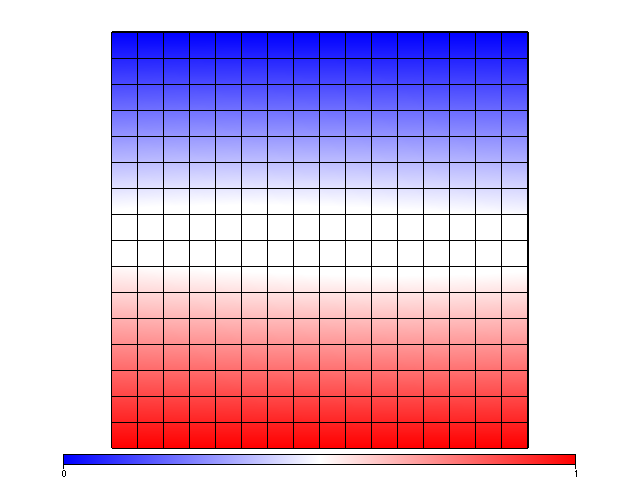

In [12]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, temperatureMesh, colours="blue white red")
figtemp.Mesh(temperatureMesh, colourBar = False)
figtemp.show()

System setup
-----

**Setup a Stokes system**

For most geodynamics problems the motion of the fluid is well described by [incompressible Stokes equation](https://en.wikipedia.org/wiki/Navier%E2%80%93Stokes_equations). In underworld setting up such as system requires the velocity field, pressure, viscosity and buoyancy forces be passed to the Stokes system function. Along with the conditions affecting these variables - in this case the boundary conditions for the velocity field.

This system is solved after each time step using the .solve function (see main loop below).

In [13]:
stokesPIC = uw.systems.Stokes( velocityField = velocityField, 
                               pressureField = pressureField,
                               conditions    = [freeslipBC,],
                               viscosityFn   = viscosityFn, 
                               bodyForceFn   = buoyancyFn )


**Create an advective diffusive system**

For the heat transport in the system the advection diffusion equation is solved for the temperature field. This is used in tandem with the Stokes system, which solves for the velocity field given the temperature and pressure fields (above). More information on the advection diffusion equation can be found [here](https://en.wikipedia.org/wiki/Convection%E2%80%93diffusion_equation).

Similar to the Stokes system, the advection diffusion system is setup in underworld by flagging the temperature and velocity field variables as well as the temperature boundary conditions.

In [14]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,], )

Main time loop
-----

The main time stepping loop begins here. Before this the time and number of timesteps are initialised to zero. For this particular example the simulation is run for long enough to see convection beginning.


In [15]:
time = 0.
step = 0
steps_end = 10
while step < steps_end:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep size   
    advDiff.integrate(dt)
    step += 1

**Plot final temperature field**

The temperature field will now be close to steady-state conditions due to convection. To see this we re-run the plotter used above.

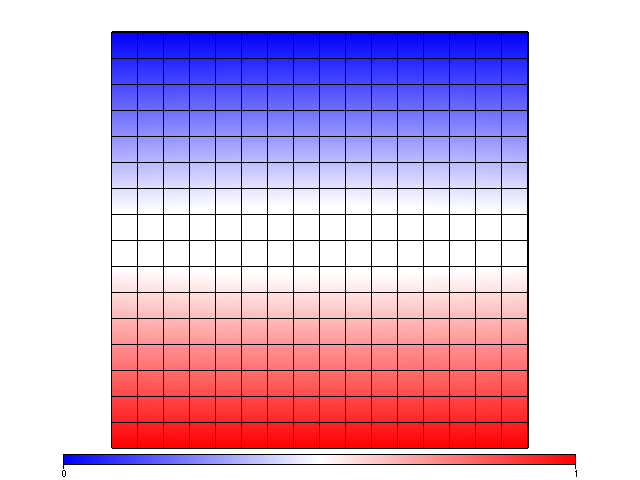

In [16]:
figtemp = plt.Figure()
figtemp.Surface(temperatureField, temperatureMesh, colours="blue white red")
figtemp.Mesh(temperatureMesh, colourBar = False)
figtemp.show()

**Overlay with velocity field**

To show the convective motion of the fluid when the temperature is in steady state we overlay the velocity field over the previous temperature field plot.

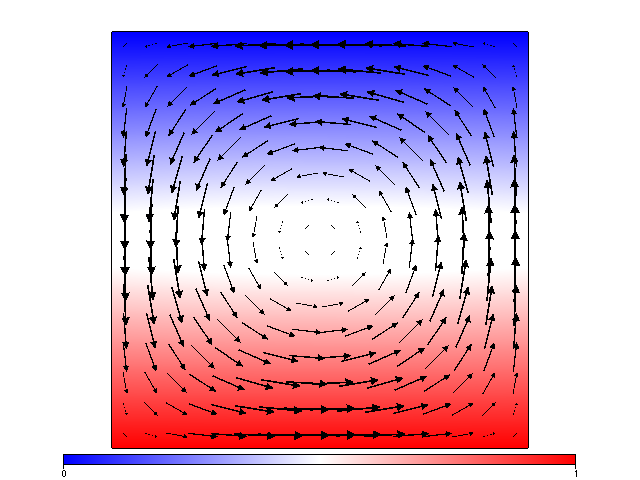

In [17]:
# calculate the velocity magnitude at each point
velmagfield = uw.function.math.sqrt(uw.function.math.dot(velocityField,velocityField))

# enter the approximate maximum velocity (for plotting aesthetics)
velplotmax = 0.15

# plot figure
figWithV = plt.Figure()
figWithV.Surface(temperatureField, temperatureMesh, colours="blue white red")
figWithV.VectorArrows(velocityField/(1.5*velplotmax), temperatureMesh, arrowHeadSize=0.2, lengthScale=0.2)
figWithV.show()